# Import modules

In [ ]:
import pandas as pd
import pickle
import torch
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, tqdm_notebook
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import gensim
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from collections import defaultdict
from nltk.data import load
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import os
import nltk
import spacy
import networkx as nx
nlp = spacy.load("en_core_web_sm")

data_path = 'data'

propheno_df = pd.read_csv(os.path.join(data_path, 'propheno_scoms.csv'))
propheno_df = propheno_df.dropna()
propheno_df = propheno_df[['Sentence', 'Protein', 'UniProtId', 'Phenotype', 'HPOId', 'Type']]
propheno_df = propheno_df[propheno_df['Protein'].str.len() > 1]
propheno_df = propheno_df[propheno_df['Sentence'].str.len() < 500]
propheno_df = propheno_df[~propheno_df.Sentence.str.contains('Abbreviations')]
propheno_df = propheno_df[~(propheno_df['Sentence'].str.contains(';') & (propheno_df['Sentence'].str.contains(':') | propheno_df['Sentence'].str.contains(',')))]
propheno_df.reset_index(inplace=True)

train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
validation_df = pd.read_csv(os.path.join(data_path, 'validation.csv'))
test_df = pd.read_csv(os.path.join(data_path, 'test.csv'))

pretrained_w2v = gensim.models.Word2Vec.load(os.path.join(data_path, 'word2vec_100_10_5.model'))

MAX_LEN = 80
SHORT_MAX_LEN = 25
MAX_WORDS = 30000
OOV_TOKEN = 'OOV'
TRUNCATE_MODE = 'post'
PADDING_MODE = 'post'
EMBEDDING_SIZE = 100

all_proteins = set(propheno_df['UniProtId'])
all_phenotypes = set(propheno_df['HPOId'])

class DynamicDataset(Dataset):
    def __init__(self, sequences, features, short_sequences, labels):
        self.sequences = sequences
        self.features = features
        self.short_sequences = short_sequences
        self.labels = labels

    def __getitem__(self, i):
        return (self.sequences[i], self.features[i], self.short_sequences[i], self.labels[i]) 

    def __len__(self):
        return len(self.sequences)

# Preprocessing (Load pickles)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 0

torch.manual_seed(0)
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

with open(os.path.join(data_path, 'sequences_labels.pkl'), 'rb') as handle:
    [train_sequences, train_features, train_sp_sequences, train_labels, val_sequences, val_features, val_sp_sequences, val_labels, 
    test_sequences, test_features, test_sp_sequences, test_labels, propheno_sequences, propheno_features, propheno_labels] = pickle.load(handle)
    
with open(os.path.join(data_path, 'propheno_masks.pkl'), 'rb') as handle:
    [propheno_inputs, propheno_masks, propheno_labels] = pickle.load(handle)

with open(os.path.join(data_path, 'tokenizer.pkl'), 'rb') as handle:
    tokenizer = pickle.load(handle)

with open(os.path.join(data_path, 'propheno_short.pkl'), 'rb') as handle:
    propheno_sp_sequences = pickle.load(handle)

with open(os.path.join(data_path, 'bert_predictions_propheno_new.pkl'), 'rb') as handle:
    [bert_propheno_predictions_scores, bert_propheno_flat_predictions, bert_propheno_true_labels] = pickle.load(handle)

vocab_size = len(tokenizer.word_index)

weights_matrix = np.zeros((vocab_size+1, EMBEDDING_SIZE))
for i, word in enumerate(tokenizer.word_index, start=1):
    try: 
        weights_matrix[i] = pretrained_w2v.wv[word]
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(EMBEDDING_SIZE, ))

train = DynamicDataset(train_sequences, train_features, train_sp_sequences, train_labels)
validation = DynamicDataset(val_sequences, val_features, val_sp_sequences, val_labels)
test = DynamicDataset(test_sequences, test_features, test_sp_sequences, test_labels)
propheno = DynamicDataset(propheno_sequences, propheno_features, propheno_sp_sequences, propheno_labels)

# Networks

In [ ]:
seed = 0

class MultiCnn(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        torch.manual_seed(seed)
        super(MultiCnn, self).__init__()
        ### Original Sentence
        self.word_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.word_embeddings.weight.data.copy_(torch.from_numpy(weights_matrix))
        self.conv1 = nn.Conv1d(embedding_size, 64, 3)
        self.drop1 = nn.Dropout(0.5)
        self.max_pool1 = nn.MaxPool1d(2)
        self.flat1 = nn.Flatten()

        self.conv2 = nn.Conv1d(embedding_size, 64, 5)
        self.drop2 = nn.Dropout(0.5)
        self.max_pool2 = nn.MaxPool1d(2)
        self.flat2 = nn.Flatten()
        
        ### Shortest Path
        self.s_word_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.s_word_embeddings.weight.data.copy_(torch.from_numpy(weights_matrix))
        self.s_conv1 = nn.Conv1d(embedding_size, 64, 3)
        self.s_drop1 = nn.Dropout(0.3)
        self.s_max_pool1 = nn.MaxPool1d(2)
        self.s_flat1 = nn.Flatten()

        self.s_conv2 = nn.Conv1d(embedding_size, 64, 5)
        self.s_drop2 = nn.Dropout(0.3)
        self.s_max_pool2 = nn.MaxPool1d(2)
        self.s_flat2 = nn.Flatten()
        
        ### Concatenate
        self.fc1 = nn.Linear(64*98, 100)
        self.drop4 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(100, 64)
        self.drop5 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, sentence, features, shortest):
        embedding = self.word_embeddings(sentence).permute(0, 2, 1)
        short_embedding = self.s_word_embeddings(shortest).permute(0, 2, 1)
        
        conv1 = F.relu(self.conv1(embedding))
        drop1 = self.drop1(conv1)
        max_pool1 = self.max_pool1(drop1)
        flat1 = self.flat1(max_pool1)
        
        conv2 = F.relu(self.conv2(embedding))
        drop2 = self.drop2(conv2)
        max_pool2 = self.max_pool2(drop2)
        flat2 = self.flat2(max_pool2)
    
        short_conv1 = F.relu(self.s_conv1(short_embedding))
        short_drop1 = self.s_drop1(short_conv1)
        short_max_pool1 = self.s_max_pool1(short_drop1)
        short_flat1 = self.s_flat1(short_max_pool1)
        
        short_conv2 = F.relu(self.s_conv2(short_embedding))
        short_drop2 = self.s_drop2(short_conv2)
        short_max_pool2 = self.s_max_pool2(short_drop2)
        short_flat2 = self.s_flat2(short_max_pool2)
        
        cat = torch.cat((flat1, flat2, short_flat1, short_flat2), dim=1)
        
        fc1 = F.relu(self.fc1(cat.view(len(sentence), -1)))
        drop4 = self.drop4(fc1)
        fc2 = F.relu(self.fc2(drop4))
        drop5 = self.drop5(fc2)
        fc3 = torch.sigmoid(self.fc3(drop5))
        
        return fc3

class BiLSTMShort(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        torch.manual_seed(seed)
        super(BiLSTMShort, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.word_embeddings.weight.data.copy_(torch.from_numpy(weights_matrix))
        self.bi_lstm1 = nn.LSTM(embedding_size, 32, bidirectional=True)
        self.bi_lstm2 = nn.LSTM(embedding_size, 32, bidirectional=True)

        self.fc1 = nn.Linear(64*105, 100)
        self.drop1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(100, 64)
        self.drop2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, sentence, features, shortest):
        embedding = self.word_embeddings(sentence)
        short_embedding = self.word_embeddings(shortest)
        lstm_out1, hidden1 = self.bi_lstm1(embedding)
        short_lstm_out1, short_hidden1 = self.bi_lstm2(short_embedding)
        cat = torch.cat((lstm_out1.permute(0, 2, 1), short_lstm_out1.permute(0, 2, 1)), dim=2)
        
        fc1 = F.relu(self.fc1(cat.view(len(sentence), -1)))
        drop1 = self.drop1(fc1)
        fc2 = F.relu(self.fc2(drop1))
        drop2 = self.drop2(fc2)
        fc3 = torch.sigmoid(self.fc3(drop2))
        return fc3

# Functions

In [ ]:
def print_performance(preds, true_labels):
    print('Precision: {0:4.3f}, Recall: {1:4.3f}, F1: {2:4.3f}, AUROC: {3:4.3f}'.format(precision_score(true_labels, preds), recall_score(true_labels, preds), f1_score(true_labels, preds), roc_auc_score(true_labels, preds)))
    print('tn={0:d}, fp={1:d}, fn={2:d}, tp={3:d}'.format(*confusion_matrix(true_labels, preds).ravel()))
    print('{0:4.3f} {1:4.3f} {2:4.3f} {3:4.3f}'.format(precision_score(true_labels, preds), recall_score(true_labels, preds), f1_score(true_labels, preds), roc_auc_score(true_labels, preds)))
    
def train_model(model, dataset, epochs=20, echo=False):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loader = DataLoader(dataset, batch_size=32)

    # model.train()
    for epoch in range(epochs):
        model.train()
        progress = tqdm(loader, leave=False) # tqdm_notebook
        tqdm._instances.clear()
        for inputs, features, short, target in progress:
            model.zero_grad()
            output = model(inputs.to(device), features.to(device), short.to(device))
            loss = criterion(output, target.to(device))
            loss.backward()
            optimizer.step()
            tqdm._instances.clear()
        if echo:
            print(epoch, loss)
    return model

def concatenate_sequences(sequences, features, shorts, labels, added_sequences, added_features, added_shorts, added_labels):
    sequences = torch.cat((sequences, added_sequences))
    features = np.concatenate((features, added_features))
    shorts = np.concatenate((shorts, added_shorts))
    labels = torch.cat((labels, added_labels))
    return sequences, features, shorts, labels

def eval_model(model, dataset, indices=None, return_binary=False, threshold=None):
    if indices is not None:
        dataset = DynamicDataset(dataset[indices][0], dataset[indices][1], dataset[indices][2], dataset[indices][3])
    
    loader = DataLoader(dataset, batch_size=32)
    predictions , true_labels = [], []
    model.eval()
    cnt = 0
    for batch in loader:
        batch = tuple(t.to(device) for t in batch)
        inputs, features, shorts, labels = batch
        with torch.no_grad():
            logits = model(inputs.to(device), features.to(device), shorts.to(device))

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)
        
        cnt += 1
        if threshold and cnt == threshold:
            break
    
    predictions = [item for sublist in predictions for item in sublist]
    if return_binary:
        predictions = np.array([1 if pred[0] > 0.5 else 0 for pred in predictions])
    labels = [item[0] for sublist in true_labels for item in sublist]
    
    return predictions, labels

def print_stats(dataset):
    print('Length of input dataset: {0:d}'.format(len(dataset)))
    print('Positive instances: {0:d} ({1:4.2f}), Negative instances: {2:d} ({3:4.2f})'.format(sum(dataset.labels == 1)[0], int(sum(dataset.labels == 1)[0]) / len(dataset), sum(dataset.labels == 0)[0], int(sum(dataset.labels == 0)[0]) / len(dataset)))
    
def create_model(input_value, model_type='all', network=None):
    model = network(vocab_size+1, EMBEDDING_SIZE)
    model.cuda()
    print_stats(train)
    model = train_model(model, train)

    print_performance(*eval_model(model, validation, return_binary=True))
    
    indices = None
    if model_type == 'uniprot':
        # indices = list(uniprot_indices[input_value])
        indices = propheno_df[propheno_df.UniProtId == input_value].index.to_numpy()
    elif model_type == 'hpo':
        # indices = list(hpo_indices[input_value])
        indices = propheno_df[propheno_df.HPOId == input_value].index.to_numpy()
    predictions, labels = eval_model(model, propheno, indices=indices)
    
    instances = []
    label_instances = []
    
    instance_threshold = 1000 
    max_cnt = 0

    if model_type == 'all':
        for i in range(len(predictions)):
            if predictions[i][0] <= 0.02:
                instances.append(i)
        pos_cnt = len(instances)
        for i in range(len(predictions)):
            if pos_cnt == 0:
                break
            if predictions[i][0] >= 0.98:
                instances.append(i)
                pos_cnt -= 1
    else:
        for i, idx in enumerate(indices):
            if predictions[i][0] <= 0.02:
                instances.append(idx)
                label_instances.append(i)
                max_cnt += 1
                if max_cnt == instance_threshold:
                    break
        pos_cnt = len(instances)
        for i, idx in enumerate(indices):
            if pos_cnt == 0:
                break
            if predictions[i][0] >= 0.98:
                instances.append(idx)
                label_instances.append(i)
                pos_cnt -= 1
    
    instances = np.array(instances, dtype=int)
    label_instances = np.array(label_instances, dtype=int)
    predictions = np.array([1 if pred[0] > 0.5 else 0 for pred in predictions])
    added_sequences, added_features, added_shorts, added_labels = concatenate_sequences(train_sequences, train_features, train_sp_sequences, train_labels, 
                                                                                        propheno_sequences[instances], propheno_features[instances], propheno_sp_sequences, 
                                                                                        torch.from_numpy(predictions[label_instances].reshape(-1, 1)).float())

    dataset = DynamicDataset(added_sequences, added_features, added_shorts, added_labels)
    print_stats(dataset)
    model = train_model(model, dataset)

    print_performance(*eval_model(model, validation, return_binary=True))
    
    save_model(model, input_value.replace(':', ''), model_type=model_type)
    
    return model

# Evaluations

In [ ]:
seed = 0

torch.manual_seed(seed)
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train = DynamicDataset(train_sequences, train_features, train_sp_sequences, train_labels)

def run_model(network):
    model = network(vocab_size+1, EMBEDDING_SIZE)
    model.cuda()
    EPOCHS = 20
    train_model(model, train, epochs=EPOCHS, echo=True)
    return model

time1 = time.time()
rnn_model = run_model(BiLSTMShort)
time2 = time.time()
print(time2 - time1)
time1 = time.time()
cnn_model = run_model(MultiCnn)
time2 = time.time()
print(time2 - time1)

predictions, true_labels = eval_model(rnn_model, test, return_binary=True)
print_performance(predictions, true_labels)

predictions, true_labels = eval_model(cnn_model, test, return_binary=True)
print_performance(predictions, true_labels)

In [ ]:
lengths = test_df.Sentence.str.len()
predictions, true_labels = eval_model(rnn_model, test, return_binary=True)
corrects_rnn = lengths[np.where(predictions == true_labels)[0]]
predictions, true_labels = eval_model(cnn_model, test, return_binary=True)
corrects_cnn = lengths[np.where(predictions == true_labels)[0]]

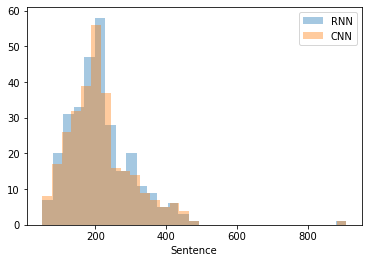

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(corrects_rnn, kde=False, label='RNN');
sns.distplot(corrects_cnn, kde=False, label='CNN');
plt.legend(loc='upper right')

In [ ]:
### Only validation set

predictions, true_labels = eval_model(rnn_model, validation, return_binary=True)
print_performance(predictions, true_labels)

predictions, true_labels = eval_model(cnn_model, validation, return_binary=True)
print_performance(predictions, true_labels)

import statistics

sigmoid = lambda x: 1 / (1 + np.exp(-x))

bert_predictions = [item for sublist in t_predictions for item in sublist]

for i, v in enumerate(bert_predictions):
    bert_predictions[i] = sigmoid(v[1])

def get_majority_vote(r, c, b):
    predictions = []
    for i in range(len(r)):
        predictions.append([1 if r[i] >= 0.5 else 0, 1 if c[i] >= 0.5 else 0, 1 if b[i] >= 0.5 else 0])
    return list(map(statistics.mode, predictions))

cnn_predictions, cnn_true_labels = eval_model(cnn_model, validation, return_binary=False)
rnn_predictions, rnn_true_labels = eval_model(rnn_model, validation, return_binary=False)

avg_preds = [1 if x >= 0.5 else 0 for x in np.mean((rnn_predictions, cnn_predictions), axis=0)]
print_performance(avg_preds, cnn_true_labels)

trp_preds = [1 if x >= 0.5 else 0 for x in np.mean((rnn_predictions, cnn_predictions, bert_predictions), axis=0)]
print_performance(trp_preds, cnn_true_labels)

maj_test = get_majority_vote(rnn_predictions, cnn_predictions, bert_predictions)
print_performance(maj_test, cnn_true_labels)

Precision: 0.710, Recall: 0.817, F1: 0.760, AUROC: 0.599
tn=45, fp=73, fn=40, tp=179
0.710 0.817 0.760 0.599
Precision: 0.714, Recall: 0.776, F1: 0.744, AUROC: 0.600
tn=50, fp=68, fn=49, tp=170
0.714 0.776 0.744 0.600
Precision: 0.708, Recall: 0.785, F1: 0.745, AUROC: 0.592
tn=47, fp=71, fn=47, tp=172
0.708 0.785 0.745 0.592
Precision: 0.712, Recall: 0.845, F1: 0.772, AUROC: 0.605
tn=43, fp=75, fn=34, tp=185
0.712 0.845 0.772 0.605
Precision: 0.710, Recall: 0.840, F1: 0.770, AUROC: 0.602
tn=43, fp=75, fn=35, tp=184
0.710 0.840 0.770 0.602


In [ ]:
rnn_model = load_model('rnn_seed_' + str(seed), 'traintest')
cnn_model = load_model('cnn_seed_' + str(seed), 'traintest')
# bert_model = load_model('bert_seed_2', 'traintest')

In [ ]:
import statistics

sigmoid = lambda x: 1 / (1 + np.exp(-x))

bert_predictions = [item for sublist in t_predictions for item in sublist]

for i, v in enumerate(bert_predictions):
    bert_predictions[i] = sigmoid(v[1])

def get_majority_vote(r, c, b):
    predictions = []
    for i in range(len(r)):
        predictions.append([1 if r[i] >= 0.5 else 0, 1 if c[i] >= 0.5 else 0, 1 if b[i] >= 0.5 else 0])
    return list(map(statistics.mode, predictions))

cnn_predictions, cnn_true_labels = eval_model(cnn_model, test, return_binary=False)
rnn_predictions, rnn_true_labels = eval_model(rnn_model, test, return_binary=False)

avg_preds = [1 if x >= 0.5 else 0 for x in np.mean((rnn_predictions, cnn_predictions), axis=0)]
print_performance(avg_preds, cnn_true_labels)

trp_preds = [1 if x >= 0.5 else 0 for x in np.mean((rnn_predictions, cnn_predictions, bert_predictions), axis=0)]
print_performance(trp_preds, cnn_true_labels)

maj_test = get_majority_vote(rnn_predictions, cnn_predictions, bert_predictions)
print_performance(maj_test, cnn_true_labels)

Precision: 0.890, Recall: 0.906, F1: 0.898, AUROC: 0.843
tn=89, fp=25, fn=21, tp=202
0.890 0.906 0.898 0.843
Precision: 0.887, Recall: 0.955, F1: 0.920, AUROC: 0.859
tn=87, fp=27, fn=10, tp=213
0.887 0.955 0.920 0.859
Precision: 0.891, Recall: 0.951, F1: 0.920, AUROC: 0.861
tn=88, fp=26, fn=11, tp=212
0.891 0.951 0.920 0.861


In [ ]:
### Run in loop

for seed in range(15):
    torch.manual_seed(seed)
    np.random.seed(1)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    train = DynamicDataset(train_sequences, train_features, train_sp_sequences, train_labels)

    def run_model(network):
        model = network(vocab_size+1, EMBEDDING_SIZE)
        model.cuda()
        EPOCHS = 20
        train_model(model, train, epochs=EPOCHS, echo=False)
        return model

    rnn_model = run_model(BiLSTMShort)
    cnn_model = run_model(MultiCnn)

    print_performance(*eval_model(rnn_model, validation, return_binary=True))
    print_performance(*eval_model(cnn_model, validation, return_binary=True))

    rnn_predictions, rnn_true_labels = eval_model(rnn_model, validation, return_binary=False)
    cnn_predictions, cnn_true_labels = eval_model(cnn_model, validation, return_binary=False)

    avg_preds = [1 if x >= 0.5 else 0 for x in np.mean((rnn_predictions, cnn_predictions), axis=0)]
    print_performance(avg_preds, true_labels)

    print('*' * 50)

    save_model(rnn_model, 'rnn_seed_' + str(seed), model_type='traintest')
    save_model(cnn_model, 'cnn_seed_' + str(seed), model_type='traintest')

Precision: 0.750, Recall: 0.795, F1: 0.772, AUROC: 0.651
tn=60, fp=58, fn=45, tp=174
0.750 0.795 0.772 0.651
Precision: 0.732, Recall: 0.763, F1: 0.747, AUROC: 0.623
tn=57, fp=61, fn=52, tp=167
0.732 0.763 0.747 0.623
Precision: 0.724, Recall: 0.767, F1: 0.745, AUROC: 0.612
tn=54, fp=64, fn=51, tp=168
0.724 0.767 0.745 0.612
**************************************************


Precision: 0.710, Recall: 0.817, F1: 0.760, AUROC: 0.599
tn=45, fp=73, fn=40, tp=179
0.710 0.817 0.760 0.599
Precision: 0.714, Recall: 0.776, F1: 0.744, AUROC: 0.600
tn=50, fp=68, fn=49, tp=170
0.714 0.776 0.744 0.600
Precision: 0.708, Recall: 0.785, F1: 0.745, AUROC: 0.592
tn=47, fp=71, fn=47, tp=172
0.708 0.785 0.745 0.592
**************************************************


Precision: 0.725, Recall: 0.781, F1: 0.752, AUROC: 0.615
tn=53, fp=65, fn=48, tp=171
0.725 0.781 0.752 0.615
Precision: 0.713, Recall: 0.849, F1: 0.775, AUROC: 0.607
tn=43, fp=75, fn=33, tp=186
0.713 0.849 0.775 0.607
Precision: 0.725, Recall: 0.817, F1: 0.768, AUROC: 0.621
tn=50, fp=68, fn=40, tp=179
0.725 0.817 0.768 0.621
**************************************************


Precision: 0.716, Recall: 0.795, F1: 0.753, AUROC: 0.605
tn=49, fp=69, fn=45, tp=174
0.716 0.795 0.753 0.605
Precision: 0.729, Recall: 0.785, F1: 0.756, AUROC: 0.622
tn=54, fp=64, fn=47, tp=172
0.729 0.785 0.756 0.622
Precision: 0.718, Recall: 0.804, F1: 0.759, AUROC: 0.609
tn=49, fp=69, fn=43, tp=176
0.718 0.804 0.759 0.609
**************************************************


Precision: 0.710, Recall: 0.826, F1: 0.764, AUROC: 0.600
tn=44, fp=74, fn=38, tp=181
0.710 0.826 0.764 0.600
Precision: 0.724, Recall: 0.790, F1: 0.755, AUROC: 0.615
tn=52, fp=66, fn=46, tp=173
0.724 0.790 0.755 0.615
Precision: 0.706, Recall: 0.822, F1: 0.759, AUROC: 0.593
tn=43, fp=75, fn=39, tp=180
0.706 0.822 0.759 0.593
**************************************************


Precision: 0.722, Recall: 0.831, F1: 0.773, AUROC: 0.619
tn=48, fp=70, fn=37, tp=182
0.722 0.831 0.773 0.619
Precision: 0.742, Recall: 0.776, F1: 0.759, AUROC: 0.638
tn=59, fp=59, fn=49, tp=170
0.742 0.776 0.759 0.638
Precision: 0.745, Recall: 0.826, F1: 0.784, AUROC: 0.651
tn=56, fp=62, fn=38, tp=181
0.745 0.826 0.784 0.651
**************************************************


Precision: 0.710, Recall: 0.795, F1: 0.750, AUROC: 0.596
tn=47, fp=71, fn=45, tp=174
0.710 0.795 0.750 0.596
Precision: 0.718, Recall: 0.790, F1: 0.752, AUROC: 0.607
tn=50, fp=68, fn=46, tp=173
0.718 0.790 0.752 0.607
Precision: 0.721, Recall: 0.813, F1: 0.764, AUROC: 0.614
tn=49, fp=69, fn=41, tp=178
0.721 0.813 0.764 0.614
**************************************************


Precision: 0.687, Recall: 0.822, F1: 0.748, AUROC: 0.564
tn=36, fp=82, fn=39, tp=180
0.687 0.822 0.748 0.564
Precision: 0.700, Recall: 0.744, F1: 0.721, AUROC: 0.576
tn=48, fp=70, fn=56, tp=163
0.700 0.744 0.721 0.576
Precision: 0.692, Recall: 0.790, F1: 0.738, AUROC: 0.569
tn=41, fp=77, fn=46, tp=173
0.692 0.790 0.738 0.569
**************************************************


Precision: 0.723, Recall: 0.836, F1: 0.775, AUROC: 0.621
tn=48, fp=70, fn=36, tp=183
0.723 0.836 0.775 0.621
Precision: 0.701, Recall: 0.772, F1: 0.735, AUROC: 0.581
tn=46, fp=72, fn=50, tp=169
0.701 0.772 0.735 0.581
Precision: 0.718, Recall: 0.826, F1: 0.769, AUROC: 0.612
tn=47, fp=71, fn=38, tp=181
0.718 0.826 0.769 0.612
**************************************************


Precision: 0.737, Recall: 0.795, F1: 0.765, AUROC: 0.635
tn=56, fp=62, fn=45, tp=174
0.737 0.795 0.765 0.635
Precision: 0.722, Recall: 0.795, F1: 0.757, AUROC: 0.613
tn=51, fp=67, fn=45, tp=174
0.722 0.795 0.757 0.613
Precision: 0.724, Recall: 0.790, F1: 0.755, AUROC: 0.615
tn=52, fp=66, fn=46, tp=173
0.724 0.790 0.755 0.615
**************************************************


Precision: 0.716, Recall: 0.772, F1: 0.743, AUROC: 0.602
tn=51, fp=67, fn=50, tp=169
0.716 0.772 0.743 0.602
Precision: 0.741, Recall: 0.785, F1: 0.763, AUROC: 0.638
tn=58, fp=60, fn=47, tp=172
0.741 0.785 0.763 0.638
Precision: 0.738, Recall: 0.772, F1: 0.754, AUROC: 0.632
tn=58, fp=60, fn=50, tp=169
0.738 0.772 0.754 0.632
**************************************************


Precision: 0.729, Recall: 0.836, F1: 0.779, AUROC: 0.630
tn=50, fp=68, fn=36, tp=183
0.729 0.836 0.779 0.630
Precision: 0.698, Recall: 0.790, F1: 0.741, AUROC: 0.577
tn=43, fp=75, fn=46, tp=173
0.698 0.790 0.741 0.577
Precision: 0.721, Recall: 0.813, F1: 0.764, AUROC: 0.614
tn=49, fp=69, fn=41, tp=178
0.721 0.813 0.764 0.614
**************************************************


Precision: 0.742, Recall: 0.790, F1: 0.765, AUROC: 0.641
tn=58, fp=60, fn=46, tp=173
0.742 0.790 0.765 0.641
Precision: 0.736, Recall: 0.790, F1: 0.762, AUROC: 0.632
tn=56, fp=62, fn=46, tp=173
0.736 0.790 0.762 0.632
Precision: 0.738, Recall: 0.785, F1: 0.761, AUROC: 0.634
tn=57, fp=61, fn=47, tp=172
0.738 0.785 0.761 0.634
**************************************************


Precision: 0.717, Recall: 0.822, F1: 0.766, AUROC: 0.610
tn=47, fp=71, fn=39, tp=180
0.717 0.822 0.766 0.610
Precision: 0.715, Recall: 0.813, F1: 0.761, AUROC: 0.606
tn=47, fp=71, fn=41, tp=178
0.715 0.813 0.761 0.606
Precision: 0.711, Recall: 0.799, F1: 0.753, AUROC: 0.599
tn=47, fp=71, fn=44, tp=175
0.711 0.799 0.753 0.599
**************************************************


Precision: 0.724, Recall: 0.840, F1: 0.778, AUROC: 0.623
tn=48, fp=70, fn=35, tp=184
0.724 0.840 0.778 0.623
Precision: 0.719, Recall: 0.758, F1: 0.738, AUROC: 0.604
tn=53, fp=65, fn=53, tp=166
0.719 0.758 0.738 0.604
Precision: 0.704, Recall: 0.813, F1: 0.754, AUROC: 0.589
tn=43, fp=75, fn=41, tp=178
0.704 0.813 0.754 0.589
**************************************************


# Ensemble Model

In [ ]:
### CNN and RNN together

torch.manual_seed(0)
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

sigmoid = lambda x: 1 / (1 + np.exp(-x))
bert_prediction_scores = [item for sublist in bert_propheno_predictions_scores for item in sublist]
for i, v in enumerate(bert_prediction_scores):
    bert_prediction_scores[i] = sigmoid(v[1])
bert_prediction_scores = np.array(bert_prediction_scores)

added_length = 5000

rnn_val_predictions = []
cnn_val_predictions = []
rnn_test_predictions = []
cnn_test_predictions = []

rands = np.random.randint(propheno_df.shape[0], size=150000)
elig_rands = np.where((bert_prediction_scores[rands] > 0.8) | (bert_prediction_scores[rands] < 0.2))[0]

for i in range(0, 1):
    instances = rands[elig_rands[i * added_length: (i+1) * added_length]]
    
    new_train_sequences = torch.cat((train_sequences, propheno_sequences[instances]))
    new_train_features = torch.cat((train_features, propheno_features[instances].float()))
    new_train_sp_sequences = torch.cat((train_sp_sequences, propheno_sp_sequences[instances]))
    new_train_labels = torch.cat((train_labels, torch.from_numpy(bert_propheno_flat_predictions[instances].reshape(-1, 1)).float()))
    tmp_train = DynamicDataset(new_train_sequences, new_train_features, new_train_sp_sequences, new_train_labels)

    ### RNN
    print_stats(tmp_train)
    semi_model = BiLSTMShort(vocab_size+1, EMBEDDING_SIZE) ## BiLSTMShort
    EPOCHS = 20
    semi_model.cuda()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(semi_model.parameters(), lr=0.001)
    loader = DataLoader(tmp_train, batch_size=32)

    time1 = time.time()
    semi_model.train()
    for epoch in range(EPOCHS):
        progress = tqdm(loader, leave=False) 
        tqdm._instances.clear()
        for inputs, features, shorts, target in progress:
            semi_model.zero_grad()
            output = semi_model(inputs.to(device), features.to(device), shorts.to(device))
            loss = criterion(output, target.to(device))
            loss.backward()
            optimizer.step()
            tqdm._instances.clear()
    time2 = time.time()
    print('Time RNN:', time2 - time1)
    print('RNN:')
    print_performance(*eval_model(semi_model, validation, return_binary=True))
    print_performance(*eval_model(semi_model, test, return_binary=True))
    rnn_val_predictions.append(eval_model(semi_model, validation, return_binary=False)[0])
    rnn_predictions, rnn_true_labels = eval_model(semi_model, test, return_binary=False)
    rnn_test_predictions.append(rnn_predictions)

    ### CNN
    print_stats(tmp_train)
    semi_model = MultiCnn(vocab_size+1, EMBEDDING_SIZE)
    EPOCHS = 20
    semi_model.cuda()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(semi_model.parameters(), lr=0.001)
    loader = DataLoader(tmp_train, batch_size=32)

    time1 = time.time()
    semi_model.train()
    for epoch in range(EPOCHS):
        progress = tqdm(loader, leave=False) # tqdm_notebook
        tqdm._instances.clear()
        for inputs, features, shorts, target in progress:
            semi_model.zero_grad()
            output = semi_model(inputs.to(device), features.to(device), shorts.to(device))
            loss = criterion(output, target.to(device))
            loss.backward()
            optimizer.step()
            tqdm._instances.clear()
        # print(epoch, loss)
    time2 = time.time()
    print('Time CNN:', time2 - time1)
    print('CNN:')
    print_performance(*eval_model(semi_model, validation, return_binary=True))
    print_performance(*eval_model(semi_model, test, return_binary=True))
    cnn_val_predictions.append(eval_model(semi_model, validation, return_binary=False)[0])
    cnn_predictions, cnn_true_labels = eval_model(semi_model, test, return_binary=False)
    cnn_test_predictions.append(cnn_predictions)

    avg_preds = [1 if x >= 0.5 else 0 for x in np.mean((rnn_predictions, cnn_predictions), axis=0)]
    print_performance(avg_preds, cnn_true_labels)
    print('*' * 50)

# BERT

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()

!pip install pytorch-pretrained-bert pytorch-nlp

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import io

In [ ]:
torch.manual_seed(0)
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

b_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def convert_dataset(dataset, has_labels=True):
    sentences = dataset['Sentence']
    sentences = ['[CLS] ' + dataset['Sentence'][i].replace('PROT', dataset['Protein'][i]).replace('PHENO', dataset['Phenotype'][i]) + ' [SEP]' for i in dataset.index]
    if has_labels:
        labels = [1 if label == 'Good-CoM' else 0 for label in dataset['Label']]
    else:
        labels = [0] * len(sentences)
    tokenized_texts = [b_tokenizer.tokenize(sent) for sent in sentences]

    B_MAX_LEN = 100
    input_ids = [b_tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=B_MAX_LEN, dtype="long", truncating="post", padding="post")

    attention_masks = []
    for seq in input_ids:
        seq_mask = [np.float32(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return input_ids, np.array(attention_masks), np.array(labels)

train_inputs, train_masks, train_b_labels = convert_dataset(train_df)
validation_inputs, validation_masks, validation_b_labels = convert_dataset(validation_df)
test_inputs, test_masks, test_b_labels = convert_dataset(test_df)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

In [ ]:
### Regular BERT

# seed = 0

torch.manual_seed(seed)
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

batch_size = 32
scores = []

train_inputs = torch.tensor(train_inputs).long()
validation_inputs = torch.tensor(validation_inputs).long()
b_train_labels = torch.tensor(train_b_labels).long()
validation_labels = torch.tensor(validation_b_labels).long()
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

train_data = TensorDataset(train_inputs, train_masks, b_train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_inputs = torch.tensor(test_inputs).long()
b_test_labels = torch.tensor(test_b_labels).long()
test_masks = torch.tensor(test_masks)

test_data = TensorDataset(test_inputs, test_masks, b_test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                    lr=2e-5,
                    warmup=.1)

t = [] 
train_loss_set = []
epochs = 4

time1 = time.time()

for _ in trange(epochs, desc="Epoch"):
    model.train()

    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
        loss.backward()
        optimizer.step()

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

# Prediction on validation set
model.eval()
t_predictions , true_labels = [], []

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    t_predictions.append(logits)
    true_labels.append(label_ids)

flat_predictions = [item for sublist in t_predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

print_performance(flat_predictions, flat_true_labels)


# Prediction on test set
model.eval()
t_predictions , true_labels = [], []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    t_predictions.append(logits)
    true_labels.append(label_ids)

flat_predictions = [item for sublist in t_predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

print_performance(flat_predictions, flat_true_labels)

time2 = time.time()

print(time2 - time1)

In [ ]:
with open(os.path.join(data_path, 'propheno_masks.pkl'), 'rb') as handle:
    [propheno_inputs, propheno_masks, propheno_labels] = pickle.load(handle)

In [ ]:
### Semi-sup BERT

torch.manual_seed(0)
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

batch_size = 32
scores = []

train_inputs = torch.tensor(train_inputs).long()
validation_inputs = torch.tensor(validation_inputs).long()
train_labels = torch.tensor(train_labels).long()
validation_labels = torch.tensor(val_labels).long()
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

propheno_inputs = torch.tensor(propheno_inputs).long()
propheno_labels = torch.tensor([[x] for x in bert_propheno_flat_predictions]).long()
propheno_masks = torch.tensor(propheno_masks)

added_length = 5000
bert_val_predictions = []
bert_test_predictions = []
rands = np.random.randint(propheno_df.shape[0], size=150000)
for i in range(0, 15): 
    instances = rands[i * added_length: (i+1) * added_length]
    
    tmp_train_inputs = torch.cat((train_inputs, propheno_inputs[instances]), dim=0)
    tmp_train_masks = torch.cat((train_masks, propheno_masks[instances]), dim=0)
    tmp_train_labels = torch.cat((train_labels, propheno_labels[instances]), dim=0)

    train_data = TensorDataset(tmp_train_inputs, tmp_train_masks, tmp_train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    test_inputs = torch.tensor(test_inputs).long()
    test_labels = torch.tensor(test_labels).long()
    test_masks = torch.tensor(test_masks)

    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    model.cuda()

    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0}
    ]

    optimizer = BertAdam(optimizer_grouped_parameters,
                        lr=2e-5,
                        warmup=.1)

    t = [] 
    train_loss_set = []
    epochs = 4

    for _ in trange(epochs, desc="Epoch"):
        model.train()

        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0

        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            optimizer.zero_grad()
            loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            train_loss_set.append(loss.item())    
            loss.backward()
            optimizer.step()

            tr_loss += loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1

        print("Train loss: {}".format(tr_loss/nb_tr_steps))

    model.eval()
    t_predictions , true_labels = [], []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        t_predictions.append(logits)
        true_labels.append(label_ids)

    flat_predictions = [item for sublist in t_predictions for item in sublist]
    # flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

    bert_val_predictions.append(flat_predictions)


    # Prediction on test set
    model.eval()
    t_predictions , true_labels = [], []

    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        t_predictions.append(logits)
        true_labels.append(label_ids)

    flat_predictions = [item for sublist in t_predictions for item in sublist]
    # flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
    flat_true_labels = [item for sublist in true_labels for item in sublist]

    bert_test_predictions.append(flat_predictions)

In [ ]:
with open(os.path.join(data_path, 'bert_predictions_propheno_new.pkl'), 'rb') as handle:
    [predictions, propheno_labels, flat_true_labels] = pickle.load(handle)

# Self-training

In [ ]:
torch.manual_seed(0)
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

length = 2000
added_sequences = torch.tensor([], dtype=torch.long)
added_features = torch.tensor([], dtype=torch.float)
added_labels = torch.tensor([], dtype=torch.float)
tmp_train = DynamicDataset(train_sequences, train_features, train_labels)

for semi_idx in range(3):
    print('Iteration #{0:d}'.format(semi_idx))
    print_stats(tmp_train)
    model = BiLSTM(vocab_size+1, EMBEDDING_SIZE) ## Need update
    EPOCHS = 20
    model.cuda()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loader = DataLoader(tmp_train, batch_size=32)

    model.train()
    for epoch in range(EPOCHS):
        progress = tqdm(loader, leave=False) # tqdm_notebook
        tqdm._instances.clear()
        for inputs, features, target in progress:
            model.zero_grad()
            output = model(inputs.to(device), features.to(device))
            loss = criterion(output, target.to(device))
            loss.backward()
            optimizer.step()
            tqdm._instances.clear()
        # print(epoch, loss)

    flat_predictions, flat_true_labels = eval_model(model, propheno, threshold=1000)

    instances = []
    for i in range(semi_idx * length, (semi_idx+1) * length):
        if flat_predictions[i][0] <= 0.02:
            instances.append(i)
    pos_cnt = len(instances)
    for i in range(semi_idx * length, (semi_idx+1) * length):
        if pos_cnt == 0:
            break
        if flat_predictions[i][0] >= 0.98:
            instances.append(i)
            pos_cnt -= 1
    instances = np.array(instances, dtype=int)
    if semi_idx == -2:
        break
    flat_predictions = np.array([1 if pred[0] >= 0.5 else 0 for pred in flat_predictions])
    added_sequences = torch.cat((added_sequences, propheno_sequences[instances]))
    added_features = torch.cat((added_features, propheno_features[instances].float()))
    added_labels = torch.cat((added_labels, torch.from_numpy(flat_predictions[instances].reshape(-1, 1)).float()))
    new_train_sequences = torch.cat((train_sequences, added_sequences))
    new_train_features = torch.cat((train_features, added_features))
    new_train_labels = torch.cat((train_labels, added_labels))
    tmp_train = DynamicDataset(new_train_sequences, new_train_features, new_train_labels)

    print_performance(*eval_model(model, validation, return_binary=True))